# Training a convnet from scratch on a small dataset
## Dog VS Cat

# 1. Data download

In [1]:
!kaggle competitions download -c dogs-vs-cats

/bin/bash: kaggle: command not found


In [2]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
replace train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


# 2. Devide Data to Train, Validation, Test

In [6]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

In [7]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg"
                 for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                           dst=dir / fname)

In [8]:
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

FileExistsError: [Errno 17] File exists: 'cats_vs_dogs_small/train/cat'

Train 2000 images  
Test  1000 images  
Val   2000 images

# 3. Data preprocessing
- Key Function   
image_dataset_from_directory()

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory


# Generates a tf.data.Dataset from image files in a directory.
# Read image file and transform to RGB file
# cast dt to tf.float
# Resize tensor input size
# Configure Batch size
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


# 4. Build & Train Model

## 4.1 Build Model

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x) 
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856 

In [12]:
model.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=["accuracy"])

## 4.2 Train model

In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

In [14]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30
63/63 [==============================] - 52s 103ms/step - loss: 1.0142 - accuracy: 0.5055 - val_loss: 0.7397 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 4s 51ms/step - loss: 0.7035 - accuracy: 0.5315 - val_loss: 0.6837 - val_accuracy: 0.5900
Epoch 3/30
63/63 [==============================] - 3s 51ms/step - loss: 0.6866 - accuracy: 0.5890 - val_loss: 0.6657 - val_accuracy: 0.5850
Epoch 4/30
63/63 [==============================] - 3s 53ms/step - loss: 0.6129 - accuracy: 0.6605 - val_loss: 0.6340 - val_accuracy: 0.6310
Epoch 5/30
63/63 [==============================] - 3s 50ms/step - loss: 0.6330 - accuracy: 0.6855 - val_loss: 0.6467 - val_accuracy: 0.6540
Epoch 6/30
63/63 [==============================] - 3s 51ms/step - loss: 0.5464 - accuracy: 0.7290 - val_loss: 0.5680 - val_accuracy: 0.6950
Epoch 7/30
63/63 [==============================] - 3s 51ms/step - loss: 0.5097 - accuracy: 0.7480 - val_loss: 0.6240 - val_accuracy: 0.6310
Epoch 8/30


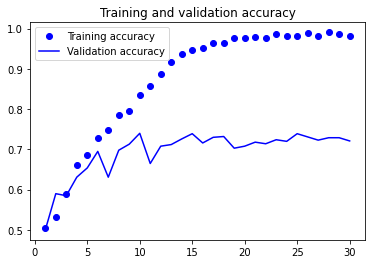

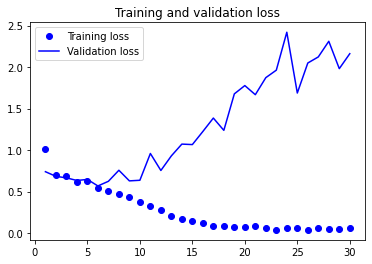

In [15]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [16]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.3f}")
print(f"Test loss: {test_loss:.3f}")

63/63 [==============================] - 5s 53ms/step - loss: 0.5850 - accuracy: 0.7010
Test Accuracy: 0.701
Test loss: 0.585


# 5. Imporve the performance of model

## 5.1 Augmentation

In [17]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

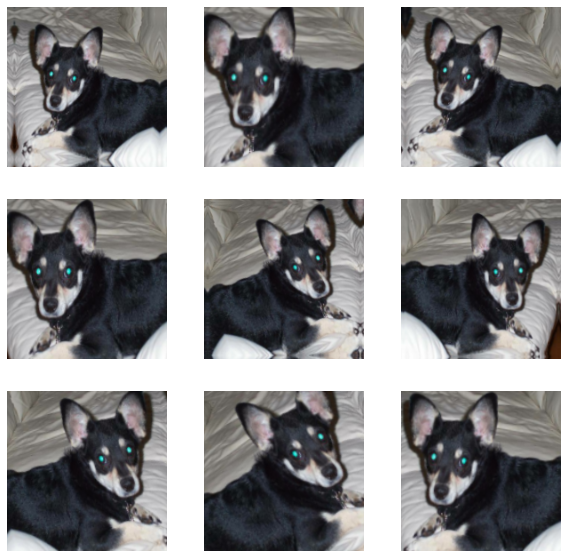

In [18]:
plt.figure(figsize=(10,10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [19]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x) 
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=["accuracy"])

In [20]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

Because we expect overfitting to occur much later during training, we will train for three times as many epochs—one hundred.

In [21]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
63/63 [==============================] - 4s 50ms/step - loss: 0.7204 - accuracy: 0.5205 - val_loss: 0.9198 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 3s 47ms/step - loss: 0.6953 - accuracy: 0.5325 - val_loss: 1.5403 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 3s 46ms/step - loss: 0.6856 - accuracy: 0.5880 - val_loss: 0.6719 - val_accuracy: 0.5390
Epoch 4/100
63/63 [==============================] - 3s 46ms/step - loss: 0.6341 - accuracy: 0.6495 - val_loss: 0.6257 - val_accuracy: 0.6420
Epoch 5/100
63/63 [==============================] - 3s 46ms/step - loss: 0.6045 - accuracy: 0.6750 - val_loss: 0.6166 - val_accuracy: 0.6540
Epoch 6/100
63/63 [==============================] - 3s 47ms/step - loss: 0.5707 - accuracy: 0.7155 - val_loss: 0.5710 - val_accuracy: 0.6840
Epoch 7/100
63/63 [==============================] - 3s 47ms/step - loss: 0.5410 - accuracy: 0.7380 - val_loss: 0.5952 - val_accuracy: 0.6810
Epoch 

63/63 [==============================] - 3s 48ms/step - loss: 0.1038 - accuracy: 0.9760 - val_loss: 2.9192 - val_accuracy: 0.7560
Epoch 59/100
63/63 [==============================] - 3s 48ms/step - loss: 0.0618 - accuracy: 0.9830 - val_loss: 2.4278 - val_accuracy: 0.7690
Epoch 60/100
63/63 [==============================] - 3s 47ms/step - loss: 0.0523 - accuracy: 0.9860 - val_loss: 2.5589 - val_accuracy: 0.7540
Epoch 61/100
63/63 [==============================] - 3s 48ms/step - loss: 0.0815 - accuracy: 0.9820 - val_loss: 3.4456 - val_accuracy: 0.7470
Epoch 62/100
63/63 [==============================] - 3s 47ms/step - loss: 0.0670 - accuracy: 0.9855 - val_loss: 2.8078 - val_accuracy: 0.7490
Epoch 63/100
63/63 [==============================] - 3s 47ms/step - loss: 0.0796 - accuracy: 0.9810 - val_loss: 2.5416 - val_accuracy: 0.7620
Epoch 64/100
63/63 [==============================] - 3s 47ms/step - loss: 0.0416 - accuracy: 0.9880 - val_loss: 3.0188 - val_accuracy: 0.7640
Epoch 65/100

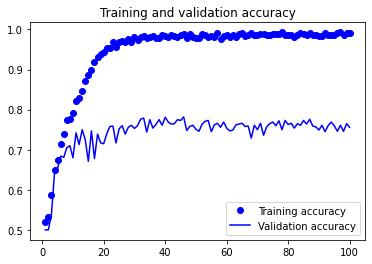

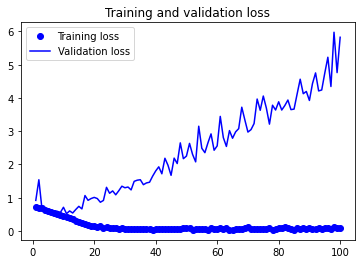

In [22]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [23]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.3f}")
print(f"Test loss: {test_loss:.3f}")

63/63 [==============================] - 2s 20ms/step - loss: 0.5425 - accuracy: 0.7495
Test Accuracy: 0.749
Test loss: 0.542


# 6. Leveraging a pretrained model

In [25]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180,180,3)
)

58900480/58889256 [==============================] - 0s 0us/step


In [29]:
import numpy as np

def get_features_and_labes(dataset):
    all_features = []
    all_labels = []
    
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
        
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labes(train_dataset)
val_features, val_labels = get_features_and_labes(validation_dataset)
test_features, test_labels = get_features_and_labes(test_dataset)

In [31]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
            optimizer="rmsprop",
            metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")
]

history = model.fit(
        train_features, train_labels,
        epochs=20,
        validation_data=(val_features, val_labels),
        callbacks=callbacks
)


Epoch 1/20
63/63 [==============================] - 1s 8ms/step - loss: 18.9039 - accuracy: 0.9215 - val_loss: 4.9414 - val_accuracy: 0.9710
Epoch 2/20
63/63 [==============================] - 0s 5ms/step - loss: 3.7870 - accuracy: 0.9715 - val_loss: 7.3606 - val_accuracy: 0.9630
Epoch 3/20
63/63 [==============================] - 0s 5ms/step - loss: 1.8310 - accuracy: 0.9850 - val_loss: 10.0947 - val_accuracy: 0.9580
Epoch 4/20
63/63 [==============================] - 0s 5ms/step - loss: 1.4985 - accuracy: 0.9875 - val_loss: 5.2060 - val_accuracy: 0.9730
Epoch 5/20
63/63 [==============================] - 0s 5ms/step - loss: 1.3908 - accuracy: 0.9900 - val_loss: 6.1892 - val_accuracy: 0.9710
Epoch 6/20
63/63 [==============================] - 0s 5ms/step - loss: 0.8028 - accuracy: 0.9935 - val_loss: 4.7357 - val_accuracy: 0.9780
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 0.3817 - accuracy: 0.9960 - val_loss: 4.9980 - val_accuracy: 0.9770
Epoch 8/20
63/63 [

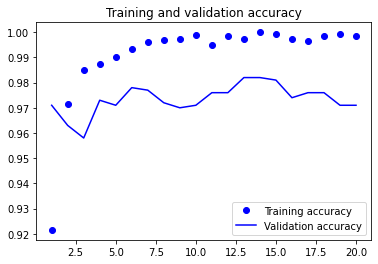

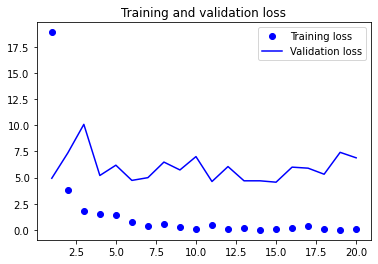

In [34]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy") 
plt.plot(epochs, val_acc, "b", label="Validation accuracy") 
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

-> Overfitting from the start despite using drop out  
-> Because of small dataset (not using augmentation)

In [35]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [39]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x - keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
            optimizer="rmsprop",
            metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
]

history = model.fit(
        train_dataset,
        epochs=50,
        validation_data=(validation_dataset),
        callbacks=callbacks
)


Epoch 1/50
63/63 [==============================] - 10s 146ms/step - loss: 29.5018 - accuracy: 0.8480 - val_loss: 16.2652 - val_accuracy: 0.8920
Epoch 2/50
63/63 [==============================] - 9s 145ms/step - loss: 11.6292 - accuracy: 0.9005 - val_loss: 6.8296 - val_accuracy: 0.9560
Epoch 3/50
63/63 [==============================] - 9s 145ms/step - loss: 8.9753 - accuracy: 0.9240 - val_loss: 5.8980 - val_accuracy: 0.9540
Epoch 4/50
63/63 [==============================] - 9s 143ms/step - loss: 7.7146 - accuracy: 0.9240 - val_loss: 6.2205 - val_accuracy: 0.9550
Epoch 5/50
63/63 [==============================] - 9s 141ms/step - loss: 6.1109 - accuracy: 0.9380 - val_loss: 7.2279 - val_accuracy: 0.9490
Epoch 6/50
63/63 [==============================] - 9s 140ms/step - loss: 5.5811 - accuracy: 0.9385 - val_loss: 4.8528 - val_accuracy: 0.9580
Epoch 7/50
63/63 [==============================] - 9s 140ms/step - loss: 4.5232 - accuracy: 0.9470 - val_loss: 8.2716 - val_accuracy: 0.9410
Ep

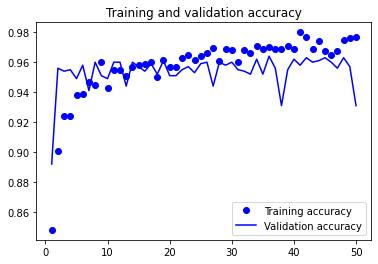

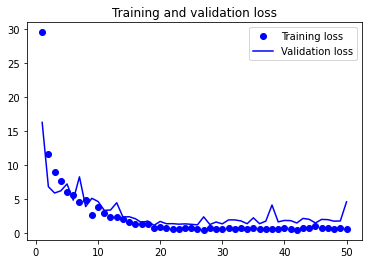

In [40]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy") 
plt.plot(epochs, val_acc, "b", label="Validation accuracy") 
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [42]:
test_model = keras.models.load_modelodelodel(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.3f}")
print(f"Test loss: {test_loss:.3f}")

AttributeError: module 'keras.api._v2.keras.models' has no attribute 'load_modelodelodel'